In [1]:
team_codes = {
    'Atletico Paranaense':'Athletico Paranaense',
    'Atletico Goianiense':'Atlético Goianiense',
    'Criciuma':'Criciúma',
    'Atletico Mineiro':'Atlético Mineiro',
    'Sao Paulo':'São Paulo',
    'Vitoria':'Vitória',
    'Mirassol':'Mirassol Futebol Clube',
    'Qingdao West Coast FC':'Qingdao Kangtaiyuan FC',
    'Zhejiang':'Zhejiang Energy Greentown',
    'Shanghai SIPG FC':'Shanghai SIPG',
    'Beijing FC':'Beijing Sinobo Guoan',
    'Wuhan Three Towns':'Wuhan Three Towns FC',
    'Cangzhou Mighty Lions':'Shijiazhuang Ever Bright',
    'Chengdu Rongcheng FC':'Chengdu Better City FC',
    'Tianjin Jinmen Tiger FC':'Tianjin Jinmen Tiger',
    'Daejeon Citizen':'Daejeon Citizen FC',
    'Pohang Steelers':'Pohang',
    'Gangwon FC':'Gangwon',
    'Ulsan Hyundai FC':'Ulsan Hyundai',
    'Jeonbuk Hyundai Motors':'Jeonbuk',
    'Mazatlán FC':'Mazatlán',
    'Atlético San Luis':'Atlético',
    'Tigres':'UANL',
    'Sarpsborg FK':'Sarpsborg 08',
    'Bragantino-SP':'Red Bull Bragantino',
    'América Mineiro':'América (MG)',
    'Clube de Regatas Brasil':'CRB',
    'Shandong Luneng Taishan FC':'Shandong Luneng Taishan',
    'Henan FC':'Henan',
    'Qingdao Hainiu FC':'Qingdao Jonoon',
    'Shanghai Shenhua FC':'Shanghai Shenhua',
    'Shenzhen Peng City FC':'Sichuan',
    'Consadole Sapporo':'Hokkaido Consadole Sapporo',
    'Pumas':'Pumas UNAM',
    'Fredrikstad FK':'Fredrikstad',
    'KFUM':'KFUM Oslo',
    'Odds BK':'Odd',
    'Viking FK':'Viking',
    'Kristiansund BK':'Kristiansund',
    'Lillestrom':'Lillestrøm',
    'Stromsgodset':'Strømsgodset',
    'SK Brann':'Brann',
    'Tromso':'Tromsø',
    'Mjällby AIF':'Mjällby',
    'Malmo FF':'Malmö',
    'IK Sirius':'Sirius',
    'Montreal Impact':'CF Montréal',
    'Orlando City SC':'Orlando City',
    'Atlanta United FC':'Atlanta United',
    'St. Louis City SC':'St. Louis City',
    'Minnesota United FC':'Minnesota United',
    'Columbus Crew SC':'Columbus Crew',
    'Brusque FC':'Brusque Futebol Clube',
    'Avai':'Avaí',
    'FC Machida Zelvia':'Machida Zelvia',
    'Hiroshima Sanfrecce FC':'Sanfrecce Hiroshima',
    'Kyoto Purple Sanga':'Kyoto Sanga',
    'Jubilo Iwata':'Júbilo Iwata',
    'Yokohama F Marinos':'Yokohama F. Marinos',
    'Daegu FC':'Daegu',
    'Sangju Sangmu FC':'Sangju Sangmu',
    'Djurgardens IF':'Djurgården',
    'IFK Norrkoping':'Norrköping',
    'IFK Värnamo':'Värnamo',
    'IF Elfsborg':'Elfsborg',
    'BK Hacken':'Häcken',
    'Kalmar FF':'Kalmar',
    'Västerås SK':'Västerås',
    'IF Brommapojkarna':'Brommapojkarna',
    'Halmstads BK':'Halmstad',
    'IFK Goteborg':'Göteborg',
    'AIK':'AIK Stockholm',
    'Hammarby IF':'Hammarby',
    'Operario PR':'Operário',
    'Inter Miami CF':'Inter Miami',
    'Instituto de Córdoba':'Central Córdoba (SdE)',
    'CA Tigre BA':'Tigre',
    'Gimnasia La Plata':'Gimnasia y Esgrima (LP)',
    'Atlético Tucuman':'Atlético Tucumán',
    'Velez Sarsfield BA':'Vélez Sarsfield',
    'Central Córdoba':'Central Córdoba (SdE)',
    'Lanus':'Lanús',
    'Union Santa Fe':'Unión',
    'Belgrano de Cordoba':'Belgrano',
    'CD Cobreloa':'Cobreloa',
    'Brondby IF':'Brøndby',
    'Vejle Boldklub':'Vejle BK',
    'Raków Częstochowa':'RKS Raków',
    'Cracovia Kraków':'Cracovia',
    'Helsingborgs IF':'Helsingborg',
    'IK Oddevold':'Oddevold',
    'Östers IF':'Öster',
    'Örgryte IS':'Örgryte',
    'Qarabağ FK':'Qarabağ',
    'Lincoln Red Imps FC':'Lincoln Red Imps',
    'Petrocub Hîncești':'Petrocub Sărata-Galbenă',
    'APOEL FC':'APOEL',
    'Fenerbahce':'Fenerbahçe',
    'FC Lugano':'Lugano',
    'The New Saints FC':'The New Saints',
    'Ferencváros TC':'Ferencváros',
    'ŠK Slovan Bratislava':'Slovan Bratislava',
    'Klaksvíkar Ítróttarfelag':'KÍ',
    'FK RFS':'FK Rīgas FS',
    'FC Midtjylland':'Midtjylland',
    'FK Partizan':'Partizan',
    'Jagiellonia Białystok':'Jagiellonia',
    'FC Dinamo Minsk':'Dinamo Minsk',
    'PFC Ludogorets Razgrad':'Ludogorets Razgrad',
    'FK Borac Banja Luka':'Borac Banja Luka',
    
}  

ARGENTINA PRIMERA DIVISION
8 GAMES
LAST GAMES UPDATE: 2024-07-28 00:00:00 (5 GAMES)
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
Test Accuracy: 1.42212


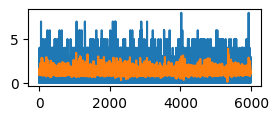

1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
   total_pred  spread_pred  total_score_pred            team_x
0    0.738836    -1.202846          2.685802  Atlético Tucumán
1    1.541131     0.516995          2.543211  Barracas Central


,total_pred,team_x
0,0.523501,Atlético Tucumán
1,1.979426,Barracas Central


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
   total_pred  spread_pred  total_score_pred              team_x
0    0.880289    -0.463627          2.241399            Platense
1    1.330464     0.278652          2.378280  Defensa y Justicia


,total_pred,team_x
0,0.794173,Platense
1,1.482630,Defensa y Justicia


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
   total_pred  spread_pred  total_score_pred             team_x
0    1.136874    -0.106379          2.335927              Tigre
1    1.096548    -0.028003          2.236478  Deportivo Riestra


,total_pred,team_x
0,1.123092,Tigre
1,1.145238,Deportivo Riestra


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
   total_pred  spread_pred  total_score_pred                 team_x
0    1.105773    -0.214977          2.410427  Central Córdoba (SdE)
1    1.194666     0.110705          2.303549        Vélez Sarsfield


,total_pred,team_x
0,1.049595,Central Córdoba (SdE)
1,1.288689,Vélez Sarsfield


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
   total_pred  spread_pred  total_score_pred              team_x
0    1.373459    -0.016801          2.726966  Argentinos Juniors
1    1.308837    -0.033326          2.645483               Lanús


,total_pred,team_x
0,1.365830,Argentinos Juniors
1,1.319045,Lanús


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
   total_pred  spread_pred  total_score_pred      team_x
0    0.973181    -0.245037          2.198074  Godoy Cruz
1    1.141526     0.002454          2.278940    Belgrano


,total_pred,team_x
0,0.978688,Godoy Cruz
1,1.218631,Belgrano


Fix Teams Union Santa Fe | Rosario Central (index -1 is out of bounds for axis 0 with size 0)
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
   total_pred  spread_pred  total_score_pred        team_x
0    0.906495    -0.622559          2.501413      Banfield
1    1.513133     0.470914          2.557261  Boca Juniors


,total_pred,team_x
0,0.755482,Banfield
1,1.737257,Boca Juniors


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time
0,ARGENTINA PRIMERA DIVISION,Barracas Central,Atlético Tucumán,1.979426,0.523501,https://cdn.ssref.net/req/202406281/tlogo/fb/1...,https://cdn.ssref.net/nocdn/tlogo/fb/42a1ab8b.png,81.66,07/29/2024 02:00 PM
1,ARGENTINA PRIMERA DIVISION,Defensa y Justicia,Platense,1.48263,0.794173,https://cdn.ssref.net/req/202406281/tlogo/fb/a...,https://cdn.ssref.net/nocdn/tlogo/fb/3cbfa767.png,66.71,07/29/2024 03:30 PM
2,ARGENTINA PRIMERA DIVISION,Central Córdoba (SdE),Vélez Sarsfield,1.049595,1.288689,https://cdn.ssref.net/req/202406281/tlogo/fb/9...,https://cdn.ssref.net/req/202406281/tlogo/fb/4...,55.85,07/29/2024 05:45 PM
3,ARGENTINA PRIMERA DIVISION,Tigre,Deportivo Riestra,1.123092,1.145238,https://cdn.ssref.net/req/202406281/tlogo/fb/0...,https://cdn.ssref.net/req/202406281/tlogo/fb/b...,49.45,07/29/2024 05:45 PM
4,ARGENTINA PRIMERA DIVISION,Argentinos Juniors,Lanús,1.36583,1.319045,https://cdn.ssref.net/req/202406281/tlogo/fb/d...,https://cdn.ssref.net/req/202406281/tlogo/fb/1...,51.09,07/29/2024 08:00 PM
5,ARGENTINA PRIMERA DIVISION,Belgrano,Godoy Cruz,1.218631,0.978688,https://cdn.ssref.net/req/202406281/tlogo/fb/7...,https://cdn.ssref.net/req/202406281/tlogo/fb/a...,56.02,07/29/2024 08:00 PM
6,ARGENTINA PRIMERA DIVISION,Boca Juniors,Banfield,1.737257,0.755482,https://cdn.ssref.net/req/202407241/tlogo/fb/7...,https://cdn.ssref.net/req/202406281/tlogo/fb/0...,72.47,07/31/2024 07:30 PM


AUSTRIA BUNDESLIGA
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


BELGIUM FIRST DIV
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


BRAZIL CAMPEONATO
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


BRAZIL SERIE B
3 GAMES
LAST GAMES UPDATE: 2024-07-28 00:00:00 (5 GAMES)
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step
Test Accuracy: 1.43519


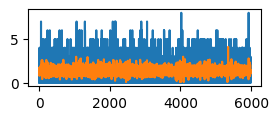

1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
   total_pred  spread_pred  total_score_pred                team_x
0    1.337944    -0.150694           2.83246  Grêmio Novorizontino
1    1.369527    -0.093195           2.83832              Paysandu


,total_pred,team_x
0,1.370502,Grêmio Novorizontino
1,1.422368,Paysandu


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
   total_pred  spread_pred  total_score_pred       team_x
0    0.899339    -0.949189          2.751081  Amazonas FC
1    1.539844     0.216873          2.869921        Goiás


,total_pred,team_x
0,0.822014,Amazonas FC
1,1.864900,Goiás


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
   total_pred  spread_pred  total_score_pred         team_x
0    1.623214     0.368652          2.885390           Avaí
1    0.839199    -1.058678          2.739923  Botafogo (SP)


,total_pred,team_x
0,1.986337,Avaí
1,0.709665,Botafogo (SP)


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time
0,BRAZIL SERIE B,Paysandu,Grêmio Novorizontino,1.422368,1.370502,https://cdn.ssref.net/req/202407241/tlogo/fb/8...,https://cdn.ssref.net/req/202407241/tlogo/fb/7...,51.18,07/29/2024 05:30 PM
1,BRAZIL SERIE B,Goiás,Amazonas FC,1.8649,0.822014,https://cdn.ssref.net/req/202407241/tlogo/fb/7...,https://cdn.ssref.net/req/202407241/tlogo/fb/3...,73.02,07/29/2024 08:00 PM
2,BRAZIL SERIE B,Avaí,Botafogo (SP),1.986337,0.709665,https://cdn.ssref.net/req/202407241/tlogo/fb/f...,https://cdn.ssref.net/req/202407241/tlogo/fb/3...,77.52,07/30/2024 08:00 PM


CHILE CAMPEONATO
1 GAMES
LAST GAMES UPDATE: 2024-07-28 00:00:00 (5 GAMES)
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
Test Accuracy: 1.43261


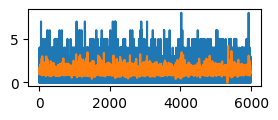

1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
   total_pred  spread_pred  total_score_pred     team_x
0    1.017417    -0.663590          2.709512   Cobreloa
1    1.637880     0.598448          2.675453  Palestino


,total_pred,team_x
0,0.796535,Cobreloa
1,1.883537,Palestino


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time
0,CHILE CAMPEONATO,Cobreloa,Palestino,0.796535,1.883537,https://cdn.ssref.net/req/202407241/tlogo/fb/6...,https://cdn.ssref.net/req/202407241/tlogo/fb/f...,73.92,07/29/2024 08:00 PM


CHINA SUPERLEAGUE
1 GAMES
LAST GAMES UPDATE: 2024-07-28 00:00:00 (5 GAMES)
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step
Test Accuracy: 1.42374


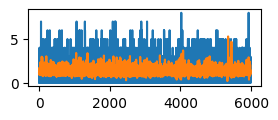

1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
   total_pred  spread_pred  total_score_pred                team_x
0    0.879437    -1.063559          2.827091  Wuhan Three Towns FC
1    1.766390     1.012701          2.522370      Shanghai Shenhua


,total_pred,team_x
0,0.477108,Wuhan Three Towns FC
1,2.187759,Shanghai Shenhua


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time
0,CHINA SUPERLEAGUE,Wuhan Three Towns FC,Shanghai Shenhua,0.477108,2.187759,https://cdn.ssref.net/req/202407241/tlogo/fb/1...,https://cdn.ssref.net/req/202407241/tlogo/fb/8...,85.15,07/29/2024 07:35 AM


CONMEBOL COPA LIBERTADORES
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


DENMARK SUPERLIGA
1 GAMES
LAST GAMES UPDATE: 2024-07-28 00:00:00 (5 GAMES)
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
Test Accuracy: 1.42530


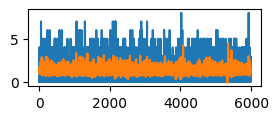

1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
   total_pred  spread_pred  total_score_pred    team_x
0    1.713948     0.088924          3.339055   Brøndby
1    1.654661    -0.051556          3.362481  Vejle BK


,total_pred,team_x
0,1.736059,Brøndby
1,1.620466,Vejle BK


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time
0,DENMARK SUPERLIGA,Brøndby,Vejle BK,1.736059,1.620466,https://cdn.ssref.net/req/202407241/tlogo/fb/a...,https://cdn.ssref.net/req/202407241/tlogo/fb/c...,52.42,07/29/2024 01:00 PM


EFL CHAMP
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


ENGLAND EFL CUP
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


ENGLAND LEAGUE1
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


ENGLAND LEAGUE2
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


EPL
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


FIFA WORLD CUP WINNER
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


FINLAND VEIKKAUSLIIGA
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


FRANCE LIGUE ONE
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


FRANCE LIGUE TWO
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


GERMANY BUNDESLIGA
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


GERMANY BUNDESLIGA2
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


GERMANY LIGA3
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


GREECE SUPER LEAGUE
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


ITALY SERIE A
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


ITALY SERIE B
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


LEAGUE OF IRELAND
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


NETHERLANDS EREDIVISIE
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


NORWAY ELITESERIEN
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


POLAND EKSTRAKLASA
1 GAMES
LAST GAMES UPDATE: 2024-07-28 00:00:00 (5 GAMES)
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
Test Accuracy: 1.43367


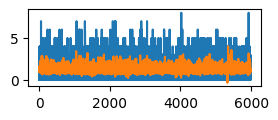

1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
   total_pred  spread_pred  total_score_pred     team_x
0    1.078802    -0.472863          2.624929   Cracovia
1    1.535699     0.485627          2.579227  RKS Raków


,total_pred,team_x
0,0.894612,Cracovia
1,1.711635,RKS Raków


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time
0,POLAND EKSTRAKLASA,RKS Raków,Cracovia,1.711635,0.894612,https://cdn.ssref.net/req/202407241/tlogo/fb/e...,https://cdn.ssref.net/req/202407241/tlogo/fb/6...,68.59,07/29/2024 01:00 PM


PORTUGAL PRIMEIRA LIGA
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


SPAIN LA LIGA
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


SPAIN SEGUNDA DIVISION
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


SPL
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


SWEDEN ALLSVENSKAN
1 GAMES
LAST GAMES UPDATE: 2024-07-28 00:00:00 (5 GAMES)
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
Test Accuracy: 1.43153


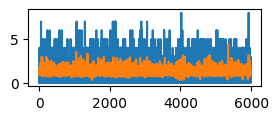

1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
   total_pred  spread_pred  total_score_pred         team_x
0    1.426764     0.019281          2.834941  AIK Stockholm
1    1.376379    -0.218755          2.974020           GAIS


,total_pred,team_x
0,1.518355,AIK Stockholm
1,1.352305,GAIS


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time
0,SWEDEN ALLSVENSKAN,AIK Stockholm,GAIS,1.518355,1.352305,https://cdn.ssref.net/req/202407241/tlogo/fb/b...,https://cdn.ssref.net/req/202407241/tlogo/fb/7...,53.72,07/29/2024 01:00 PM


SWEDEN SUPERETTAN
2 GAMES
Fix Teams Helsingborg | Östers (index -1 is out of bounds for axis 0 with size 0)
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
   total_pred  spread_pred  total_score_pred    team_x
0    1.310374     0.135045          2.482965   Örgryte
1    1.035021    -0.605877          2.676688  Oddevold


,total_pred,team_x
0,1.544173,Örgryte
1,0.957431,Oddevold


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time
0,SWEDEN SUPERETTAN,Örgryte,Oddevold,1.544173,0.957431,https://cdn.ssref.net/req/202407241/tlogo/fb/1...,https://cdn.ssref.net/req/202407241/tlogo/fb/0...,63.77,07/29/2024 01:00 PM


SWITZERLAND SUPERLEAGUE
0 GAMES


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


UEFA CHAMPS LEAGUE QUALIFICATION
14 GAMES
LAST GAMES UPDATE: 2024-07-28 00:00:00 (5 GAMES)
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step
Test Accuracy: 1.42651


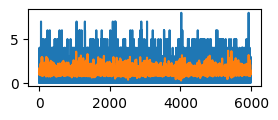

1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
   total_pred  spread_pred  total_score_pred            team_x
0    1.146901    -0.636603           2.95785  Lincoln Red Imps
1    1.570877     0.498792           2.66077           Qarabağ


,total_pred,team_x
0,0.939308,Lincoln Red Imps
1,1.839649,Qarabağ


Fix Teams Petrocub Sărata-Galbenă | APOEL FC (index -1 is out of bounds for axis 0 with size 0)
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
   total_pred  spread_pred  total_score_pred      team_x
0    2.330020     1.156628          3.569309  Fenerbahçe
1    1.264999    -1.255060          3.796149      Lugano


,total_pred,team_x
0,2.830482,Fenerbahçe
1,0.823200,Lugano


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
   total_pred  spread_pred  total_score_pred           team_x
0    0.848583    -1.175949          2.894269  Shamrock Rovers
1    2.033894     1.220836          2.835461    Sparta Prague


,total_pred,team_x
0,0.401315,Shamrock Rovers
1,2.469367,Sparta Prague


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
   total_pred  spread_pred  total_score_pred          team_x
0    0.994811    -0.692102          2.670155  The New Saints
1    2.231269     1.273653          3.211946     Ferencváros


,total_pred,team_x
0,0.593633,The New Saints
1,2.442292,Ferencváros


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
   total_pred  spread_pred  total_score_pred             team_x
0    1.397711    -0.047943          2.836043  Slovan Bratislava
1    1.604678    -0.030343          3.261783           NK Celje


,total_pred,team_x
0,1.451829,Slovan Bratislava
1,1.581700,NK Celje


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
   total_pred  spread_pred  total_score_pred team_x
0    1.004047    -0.574706          2.588281     KÍ
1    1.717378     0.658288          2.811881  Malmö


,total_pred,team_x
0,0.791755,KÍ
1,1.915260,Malmö


Fix Teams FK RFS | Bodø/Glimt (index -1 is out of bounds for axis 0 with size 0)
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
   total_pred  spread_pred  total_score_pred           team_x
0    1.126793    -0.677693          2.897508  UE Santa Coloma
1    1.457337     0.340421          2.599443      Midtjylland


,total_pred,team_x
0,0.957479,UE Santa Coloma
1,1.736197,Midtjylland


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
   total_pred  spread_pred  total_score_pred       team_x
0    1.757212     0.216466          3.323055  Dynamo Kyiv
1    1.546428    -0.044143          3.158761     Partizan


,total_pred,team_x
0,1.767017,Dynamo Kyiv
1,1.494656,Partizan


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
   total_pred  spread_pred  total_score_pred            team_x
0    1.159923    -0.244515          2.547891  Maccabi Tel Aviv
1    1.061834    -0.779242          2.959336              FCSB


,total_pred,team_x
0,1.470645,Maccabi Tel Aviv
1,1.105425,FCSB


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
   total_pred  spread_pred  total_score_pred        team_x
0    0.887127    -1.410960          3.172755  FK Panevėžys
1    2.325004     1.460531          3.190196   Jagiellonia


,total_pred,team_x
0,0.351901,FK Panevėžys
1,2.839801,Jagiellonia


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
   total_pred  spread_pred  total_score_pred              team_x
0    0.944649    -0.033963          2.004788        Dinamo Minsk
1    1.116381     0.117805          2.164108  Ludogorets Razgrad


,total_pred,team_x
0,0.944898,Dinamo Minsk
1,1.131745,Ludogorets Razgrad


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
   total_pred  spread_pred  total_score_pred            team_x
0    1.861597     0.709289          3.024075              PAOK
1    1.135395    -0.580541          2.880085  Borac Banja Luka


,total_pred,team_x
0,2.065659,PAOK
1,0.901436,Borac Banja Luka


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time
0,UEFA CHAMPS LEAGUE QUALIFICATION,Qarabağ,Lincoln Red Imps,1.839649,0.939308,https://cdn.ssref.net/req/202407241/tlogo/fb/4...,https://cdn.ssref.net/req/202407241/tlogo/fb/2...,69.82,07/30/2024 12:00 PM
1,UEFA CHAMPS LEAGUE QUALIFICATION,Fenerbahçe,Lugano,2.830482,0.8232,https://cdn.ssref.net/req/202407241/tlogo/fb/a...,https://cdn.ssref.net/req/202407241/tlogo/fb/4...,85.31,07/30/2024 01:00 PM
2,UEFA CHAMPS LEAGUE QUALIFICATION,Sparta Prague,Shamrock Rovers,2.469367,0.401315,https://cdn.ssref.net/req/202407241/tlogo/fb/e...,https://cdn.ssref.net/req/202407241/tlogo/fb/f...,89.27,07/30/2024 01:00 PM
3,UEFA CHAMPS LEAGUE QUALIFICATION,The New Saints,Ferencváros,0.593633,2.442292,https://cdn.ssref.net/req/202407241/tlogo/fb/f...,https://cdn.ssref.net/req/202407241/tlogo/fb/6...,85.54,07/30/2024 02:00 PM
4,UEFA CHAMPS LEAGUE QUALIFICATION,Slovan Bratislava,NK Celje,1.451829,1.5817,https://cdn.ssref.net/req/202407241/tlogo/fb/a...,https://cdn.ssref.net/req/202407241/tlogo/fb/c...,52.84,07/30/2024 02:30 PM
5,UEFA CHAMPS LEAGUE QUALIFICATION,KÍ,Malmö,0.791755,1.91526,https://cdn.ssref.net/req/202407241/tlogo/fb/8...,https://cdn.ssref.net/req/202407241/tlogo/fb/f...,74.55,07/30/2024 02:45 PM
6,UEFA CHAMPS LEAGUE QUALIFICATION,Midtjylland,UE Santa Coloma,1.736197,0.957479,https://cdn.ssref.net/req/202407241/tlogo/fb/3...,https://cdn.ssref.net/req/202407241/tlogo/fb/8...,67.51,07/31/2024 01:15 PM
7,UEFA CHAMPS LEAGUE QUALIFICATION,Maccabi Tel Aviv,FCSB,1.470645,1.105425,https://cdn.ssref.net/req/202407241/tlogo/fb/0...,https://cdn.ssref.net/req/202407241/tlogo/fb/a...,58.54,07/31/2024 02:00 PM
8,UEFA CHAMPS LEAGUE QUALIFICATION,Partizan,Dynamo Kyiv,1.494656,1.767017,https://cdn.ssref.net/req/202407241/tlogo/fb/d...,https://cdn.ssref.net/req/202407241/tlogo/fb/c...,55.76,07/31/2024 02:00 PM
9,UEFA CHAMPS LEAGUE QUALIFICATION,Jagiellonia,FK Panevėžys,2.839801,0.351901,https://cdn.ssref.net/req/202407241/tlogo/fb/4...,https://cdn.ssref.net/req/202407241/tlogo/fb/3...,92.63,07/31/2024 02:30 PM


UEFA EUROPA CONFERENCE LEAGUE
4 GAMES
Fix Teams FC Flora | AC Virtus (index -1 is out of bounds for axis 0 with size 0)
Fix Teams FC Pyunik | FC Struga (index -1 is out of bounds for axis 0 with size 0)
Fix Teams Ħamrun Spartans FC | FC Ballkani (index -1 is out of bounds for axis 0 with size 0)
Fix Teams FK Dečić | FC Dinamo Batumi (index -1 is out of bounds for axis 0 with size 0)


,sport,home_team,away_team,h_score,a_score,h_logo,a_logo,win_prob,time


In [2]:
import warnings
warnings.filterwarnings('ignore')
from datetime import date, datetime, timedelta
from dotenv import load_dotenv
from IPython.display import display
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pytz
import random
import requests
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Input
from sqlalchemy import create_engine

engine = create_engine('postgresql://trevor@localhost:5432/daily_lockz')

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

pd.set_option('mode.use_inf_as_na', True)
load_dotenv()
API_KEY=os.getenv('ODDS_API_KEY')
DATE = date.today()
SIM = int(999e5)
SPORTS = []

END_DATE = DATE + timedelta(days=3)
END_DATE = END_DATE.strftime('%Y-%m-%d') + 'T04:00:00Z'

all_sports = requests.get(f"https://api.the-odds-api.com/v4/sports/?apiKey={API_KEY}")
for item in all_sports.json():
    if 'soccer' in item['key']:
        SPORTS.append(item['key'])

try:
    os.remove('soccer_sims.csv')
except:
    pass

for SPORT in SPORTS:
    simulations = pd.DataFrame(columns=('sport','home_team','away_team','h_score','a_score','h_logo','a_logo','win_prob','time'))

    sport = SPORT.replace('soccer_','').replace('_',' ').upper()
    print(sport)

    response = requests.get(f'https://api.the-odds-api.com/v4/sports/{SPORT}/events?apiKey={API_KEY}&commenceTimeFrom{DATE}T04:00:00Z&commenceTimeTo={END_DATE}')
    games = response.json()
    print(f"{len(games)} GAMES")

    if sport == 'BRAZIL CAMPEONATO':
        team_codes['Botafogo'] = 'Botafogo (RJ)'
    elif sport == 'BRAZIL SERIE B':
        team_codes['Botafogo'] = 'Botafogo (SP)'

    for game in games:
        if game['home_team'] in team_codes:
            game['home_team'] = team_codes[game['home_team']]
        if game['away_team'] in team_codes:
            game['away_team'] = team_codes[game['away_team']]

    for i, game in enumerate(games):
        df = pd.read_sql('SELECT * FROM soccer_games', engine, index_col='index')
        df = df.sort_values('date').reset_index(drop=True)
        del df['index_opp']

        home_team = game['home_team']
        away_team = game['away_team']

        try:
            del df['logo_opp']
            home_logo = df[df['team'] == home_team]['logo'].iat[-1]
            away_logo = df[df['team'] == away_team]['logo'].iat[-1]
        except Exception as error:
            print(f"Fix Teams {home_team} | {away_team} ({error})")
            continue

        if i == 0:
            last_update = df['date'].iloc[-1]
            num_games = len(df[df['date'] == str(last_update)]) // 2
            print(f"LAST GAMES UPDATE: {last_update} ({num_games} GAMES)")
        
        nulls = pd.isnull(df).sum()
        nulls = nulls[nulls > 100]
        valid_columns = df.columns[~df.columns.isin(nulls.index)]
        df = df[valid_columns].copy()
        df.fillna(value=0, inplace=True)
        
        def add_target(group):
            group['total_target'] = group['total'].shift(-1)
            group['spread_target'] = group['spread'].shift(-1)
            group['total_score_target'] = group['total_score'].shift(-1)
            return group
        
        df = df.groupby('team', group_keys=False).apply(add_target)
        df['total_target'][pd.isnull(df['total_target'])] = -0.1
        df['spread_target'][pd.isnull(df['spread_target'])] = -0.1
        df['total_score_target'][pd.isnull(df['total_score_target'])] = -0.1
        df['total_target'] = df['total_target'].astype(float, errors='ignore')
        df['spread_target'] = df['spread_target'].astype(float, errors='ignore')
        df['total_score_target'] = df['total_score_target'].astype(float, errors='ignore')
        
        removed_columns = ['date','team','team_opp','logo','logo_opp','total_target','spread_target','total_score_target']
        selected_columns = df.columns[~df.columns.isin(removed_columns)]
        
        scaler = MinMaxScaler()
        df[selected_columns] = scaler.fit_transform(df[selected_columns])

        def shift_col(team, col_name):
            next_col = team[col_name].shift(-1)
            return next_col
        
        def add_col(df, col_name):
            return df.groupby('team', group_keys=False).apply(lambda x: shift_col(x, col_name))
        
        df['home_next'] = add_col(df, 'home')
        df['team_opp_next'] = add_col(df, 'team_opp')
        df['date_next'] = add_col(df, 'date')
        
        null_indices = df[(df['team'] == home_team) & (df['home_next'].isnull())].index
        for idx in null_indices:
            df.at[idx, 'home_next'] = 1
            df.at[idx, 'team_opp_next'] = away_team
            df.at[idx, 'date_next'] = DATE
        null_indices = df[(df['team'] == away_team) & (df['home_next'].isnull())].index
        for idx in null_indices:
            df.at[idx, 'home_next'] = 0
            df.at[idx, 'team_opp_next'] = home_team
            df.at[idx, 'date_next'] = DATE

        df_rolling32 = df[list(selected_columns) + ['team']]
        
        def find_team_averages32(team):
            rolling = team.rolling(32, min_periods=1).mean(numeric_only=True)
            return rolling
        
        df_rolling32 = df_rolling32.groupby(['team'], group_keys=False).apply(find_team_averages32)
        rolling_cols32 = [f"{col}_32" for col in df_rolling32.columns]
        df_rolling32.columns = rolling_cols32

        df = pd.concat([df, df_rolling32], axis=1)
        
        df = df.dropna()
        
        full = df.merge(df[rolling_cols32 + 
                        ['team_opp_next', 'date_next', 'team']], 
                        left_on=['team', 'date_next'], 
                        right_on=['team_opp_next', 'date_next'])
        
        removed_columns = list(full.columns[full.dtypes != 'float']) + removed_columns
        selected_columns = full.columns[~full.columns.isin(removed_columns)]

        if i == 0:
            train_df = full[full['total_target']!=-0.1]
            X = train_df[selected_columns].values
            y_total = train_df['total_target'].values
            y_spread = train_df['spread_target'].values
            y_total_score = train_df['total_score_target'].values

            input_layer = Input(shape=(len(selected_columns),))

            layer1 = Dense(125, activation='relu')(input_layer)
            layer2 = Dense(25, activation='relu')(layer1)
            layer3 = Dense(5, activation='relu')(layer2)

            output_total = Dense(1, name='total_output')(layer3)
            output_spread = Dense(1, name='spread_output')(layer3)
            output_total_score = Dense(1, name='total_score_output')(layer3)
            model = Model(inputs=input_layer, outputs=[output_total, output_spread, output_total_score])
            model.compile(optimizer='adam', loss='mse')

            split = TimeSeriesSplit(n_splits=5)
            early_stopping = EarlyStopping(patience=25, restore_best_weights=True)
            for train_index, test_index in split.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train_total, y_test_total = y_total[train_index], y_total[test_index]
                y_train_spread, y_test_spread = y_spread[train_index], y_spread[test_index]
                y_train_total_score, y_test_total_score = y_total_score[train_index], y_total_score[test_index]

                model.fit(X_train,
                        {'total_output': y_train_total, 'spread_output': y_train_spread, 'total_score_output': y_train_total_score},
                        epochs=125,
                        verbose=0,
                        callbacks=[early_stopping],
                        validation_data=(X_test, {'total_output': y_test_total, 'spread_output': y_test_spread, 'total_score_output': y_test_total_score}))
                
            test_df = train_df.iloc[test_index]
            test_predictions = model.predict(test_df[selected_columns])
            y_true = test_df['total_target'].values
            y_pred = test_predictions[0]
            mse = mean_squared_error(y_true, y_pred)
            print(f'Test Accuracy: {mse:.5f}')
            plt.figure(figsize=(3, 1))
            plt.plot(y_true)
            plt.plot(y_pred)
            plt.show()
            
            model.save('soccer_model.keras')
            
        model = tf.keras.models.load_model('soccer_model.keras')
        predictions = model.predict(full[selected_columns])
        full['total_pred'] = predictions[0]
        full['spread_pred'] = predictions[1]
        full['total_score_pred'] = predictions[2]

        scores = full[full['total_target'] == -0.1].reset_index()
        print(scores[['total_pred','spread_pred','total_score_pred','team_x']])

        if scores['total_pred'].iloc[0] > scores['total_pred'].iloc[1]:
            win = 0
            lose = 1
        else:
            win = 1
            lose = 0
        spread = scores['total_pred'].iloc[win] - scores['total_pred'].iloc[lose]
        total_score = scores['total_pred'].iloc[win] + scores['total_pred'].iloc[lose]

        spread += scores['spread_pred'].iloc[win]
        spread -= scores['spread_pred'].iloc[lose]
        spread /= math.sqrt(3)
            
        total_score += scores['total_score_pred'].iloc[win]
        total_score += scores['total_score_pred'].iloc[lose]
        total_score /= 3

        win_mean = (total_score + spread) / 2
        lose_mean = (total_score - spread) / 2
        if win_mean < 0:
            win_mean = 0
        if lose_mean < 0:
            lose_mean = 0
        win_team = scores['team_x'].iloc[win]
        lose_team = scores['team_x'].iloc[lose]

        win_mean = np.random.poisson(win_mean, SIM)
        lose_mean = np.random.poisson(lose_mean, SIM)

        win_score = np.mean(win_mean)
        lose_score = np.mean(lose_mean)

        win_prob = np.mean(win_mean > lose_mean) + (np.mean(win_mean == lose_mean) / 2)
        
        scores['total_pred'].iloc[win] = win_score
        scores['total_pred'].iloc[lose] = lose_score
        display(scores[['total_pred', 'team_x']])

        time = datetime.strptime(game['commence_time'], '%Y-%m-%dT%H:%M:%S%z')
        eastern = pytz.timezone('US/Eastern')
        eastern_time = time.astimezone(eastern).strftime('%m/%d/%Y %I:%M %p')

        simulations.at[i, 'sport'] = sport
        simulations.at[i, 'win_prob'] = round(win_prob * 100, 2)

        simulations.at[i, 'home_team'] = home_team
        simulations.at[i, 'away_team'] = away_team
        simulations.at[i, 'h_logo'] = home_logo
        simulations.at[i, 'a_logo'] = away_logo
        simulations.at[i, 'time'] = eastern_time

        if win_team == home_team:
            simulations.at[i, 'h_score'] = win_score
            simulations.at[i, 'a_score'] = lose_score
        else:
            simulations.at[i, 'a_score'] = win_score
            simulations.at[i, 'h_score'] = lose_score

    simulations['datetime'] = pd.to_datetime(simulations['time'], format='%m/%d/%Y %I:%M %p')
    simulations = simulations.sort_values(by=['datetime', 'home_team']).reset_index(drop=True)
    simulations = simulations.drop(columns=['datetime'])
    display(simulations)

    simulations = simulations.dropna()
    if not os.path.isfile('soccer_sims.csv'):
        simulations.to_csv('soccer_sims.csv', index=False)
    else:
        simulations.to_csv('soccer_sims.csv', mode='a', header=False, index=False)

os.remove('soccer_model.keras')